In [1]:
%%capture
!pip install jax

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import torch
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import config, random, grad, jit, vmap, lax
from huggingface_hub import notebook_login
from transformers import AutoModelForCausalLM, AutoTokenizer

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Basic algorithms

## `Theorem'.

For $\forall x \in B_2^N$ in $k$ steps, a greedy algorithm constructs vectors $u_k, ~v_k$ such that:
\begin{equation*}
    \Vert x - u_k - v_k\Vert_2 < γ^k, \quad \Vert u_k\Vert_{∞} \le \frac{C}{\sqrt{N}}, ~\Vert T v_k\Vert_{∞} \le \frac{C}{\sqrt{N}},
\end{equation*}
where $B_2^N$ is the unit ball of space $\ell_2^N$, $T \in \mathbb{O}^N$ is the group of orthogonal transformations of $\mathbb{R}^N$ with Haar measure $\mu_H$.

### Vocabulary of Greedy Algorithm

\begin{equation*}
    W = V_N ∪ T^{\ast}V_N,
\end{equation*}

where $V_N$ is the set of vertices of the cube $B_{\infty}^N$, and $T^{\ast}$ is the inverse to $T$ transformation.

## Vector decomposition

In [158]:
import jax.numpy as jnp
from jax import random
from jax.scipy.fft import dct, idct

RNG = random.PRNGKey(0)

def decomposition_vector(x, max_iter=50, tol=1e-6, key=RNG):
    n = len(x)
    matrix = random.normal(key, (n, n))
    Q, _ = jnp.linalg.qr(matrix)
    u, v = jnp.zeros(n), jnp.zeros(n)
    
    x_init = x.copy()

    def projection(x, y):
        # projection of x on y
        return (x.T@y/jnp.linalg.norm(y)**2)*y

    iter = 0
    while iter < max_iter:
        if (jnp.linalg.norm(x, 1) > jnp.linalg.norm(Q@x,1)):
            proj = projection(x, jnp.sign(x))
            u += proj
            x -= proj
        else:
            proj = projection(x, jnp.conj(Q.T )@ jnp.sign(Q @ x))
            v += proj
            x -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(x_init - u - v)
        if residual < tol:
            break

        iter += 1

    return x, u, v, residual, iter

def decomposition_vector_dct(x, max_iter=50, tol=1e-6, key=RNG):
    n = len(x)
    u, v = jnp.zeros(n), jnp.zeros(n)
    
    x_init = x.copy()

    def projection(x, y):
        # projection of x on y
        return (x.T@y/jnp.linalg.norm(y)**2)*y

    iter = 0
    while iter < max_iter:
        if (jnp.linalg.norm(x, 1) > jnp.linalg.norm(dct(x, norm='ortho'),1)):
            proj = projection(x, jnp.sign(x))
            u += proj
            x -= proj
        else:
            proj = projection(x, idct(jnp.sign(dct(x, norm='ortho')), norm='ortho'))
            v += proj
            x -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(x_init - u - v)
        if residual < tol:
            break

        iter += 1

    return x, u, v, residual, iter

def decomposition_vector_vershynin(x, delta, eta, max_iter=50, tol=1e-6, key=RNG):
    n = len(x)
    m = int(2*n)
    matrix = random.normal(key, (m, m))
    
    # Perform QR decomposition on A.T to get Q of shape n x m
    Q_, _ = jnp.linalg.qr(matrix)
    
    # Select the first n rows from Q to get a matrix of shape n x m
    Q = Q_[:n, :]
    x_init = x.copy()

    def truncation(z, M=1):
        # Compute the absolute value of z
        abs_z = jnp.abs(z)
        # Apply the transformation
        t = jnp.where(abs_z == 0, 0, z / abs_z * jnp.minimum(abs_z, M))
        return t

    # init coefficients and the truncation level
    v = jnp.zeros(m)
    M = jnp.linalg.norm(x_init)/jnp.sqrt(delta*m)

    iter = 0
    while iter < max_iter:
        # print("x", x)

        proj = truncation(Q.T@x, M)
        
        x -= Q@proj
        v += jnp.sqrt(m)*proj
        M *= eta

        # Check if termination condition is met
        residual = jnp.linalg.norm(x_init - Q@v)
        if residual < tol:
            break

        iter += 1
        print(residual)

    # while iter < max_iter:
    #     # print("x", x)

    #     proj = truncation(idct(x, norm='ortho', n=m), M)
        
    #     x -= dct(proj, norm='ortho', n=n)
    #     v += jnp.sqrt(m)*proj
    #     M *= eta

    #     # Check if termination condition is met
    #     residual = jnp.linalg.norm(x_init - dct(v, norm='ortho', n=n))
    #     print(residual)
    #     if residual < tol:
    #         break

    #     iter += 1

    return x, v, residual, iter

In [163]:
key = random.PRNGKey(42)
n = 5

x = random.normal(key, (n,))
x /= jnp.linalg.norm(x)
x_init = x.copy()
x, u, v, residual, iter = decomposition_vector(x_init, max_iter=400,key=key)
print(f"💎 Done Kashin representation of random {n} vector with {iter} iterations and residual {residual}")

# fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12, 4))
# matrix = random.normal(key, (n, n))
# Q, _ = jnp.linalg.qr(matrix)

# axs[0].hist(x_init.ravel())
# axs[1].hist(u.ravel())
# axs[2].hist((Q @ v).ravel())
# plt.show()

x, u, v, residual, iter = decomposition_vector_dct(x_init, max_iter=400,key=key)
print(f"💎 Done Kashin DCT representation of random {n} vector with {iter} iterations and residual {residual}")

x, v, residual, iter = decomposition_vector_vershynin(x_init, eta=1-1e-5, delta = 1e-5, max_iter=30,key=key)
print(f"💎 Done Kashin Vershynin representation of random {n} vector with {iter} iterations and residual {residual}")

💎 Done Kashin representation of random 5 vector with 14 iterations and residual 8.97822019396699e-07
💎 Done Kashin DCT representation of random 5 vector with 13 iterations and residual 8.983884072222281e-07
2.1622775
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
2.162278
💎 Done Kashin Vershynin representation of random 5 vector with 30 iterations and residual 2.162277936935425


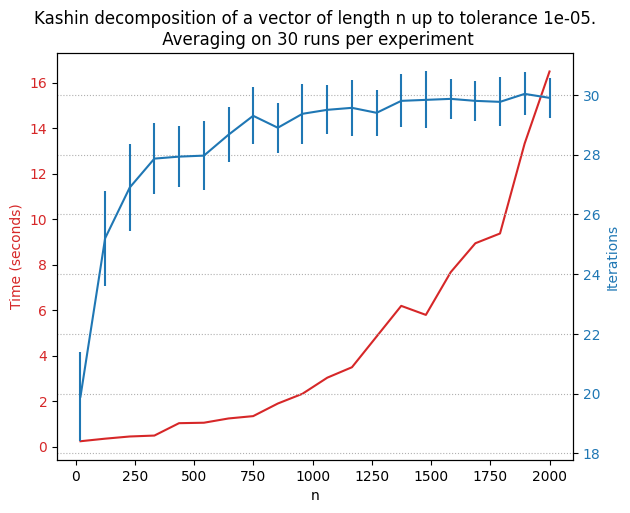

In [6]:
import jax.numpy as jnp
from jax import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import jax

# Modified function with jax.numpy.where
def decomposition_vector(x, max_iter=50, tol=1e-6, key=random.PRNGKey(0)):
    n = len(x)
    matrix = random.normal(key, (n, n))
    Q, _ = jnp.linalg.qr(matrix)
    u, v = jnp.zeros(n), jnp.zeros(n)
    
    x_init = x.copy()

    def projection(x, y):
        return (x.T @ y / jnp.linalg.norm(y)**2) * y

    def body_fun(val):
        x, u, v, iter = val
        norm_x = jnp.linalg.norm(x, 1)
        norm_Qx = jnp.linalg.norm(Q @ x, 1)

        proj = jnp.where(norm_x > norm_Qx, projection(x, jnp.sign(x)), projection(x, jnp.conj(Q.T) @ jnp.sign(Q @ x)))
        u = u + proj
        x = x - proj

        return x, u, v, iter + 1

    def cond_fun(val):
        x, u, v, iter = val
        residual = jnp.linalg.norm(x_init - u - v)
        return (residual >= tol) & (iter < max_iter)

    x, u, v, iter = jax.lax.while_loop(cond_fun, body_fun, (x, u, v, 0))
    residual = jnp.linalg.norm(x_init - u - v)

    return x, u, v, residual, iter


# Define the range of dimensions and number of experiments
dimensions = np.linspace(20, 2000, num=20, dtype=int)
k = 30  # number of runs per setup
tolerance = 1e-5

# List to store results
results = []

for dim in dimensions:
    keys = random.split(random.PRNGKey(0), k)  # Generate k random keys
    A = jnp.array([[1. / (i + j + 0.5) for i in range(dim)] for j in range(dim)])
    x = A[:, 0] / jnp.linalg.norm(A[:, 0])
    
    # Batch the x_init and keys for vmap
    x_init_batch = jnp.array([x.copy() for _ in range(k)])
    key_batch = jnp.array(keys)

    # Vectorize the decomposition function
    vectorized_decomposition = vmap(decomposition_vector, in_axes=(0, None, None, 0))

    start_time = time.time()
    # Run the vectorized function
    _, _, _, residuals, iterations = vectorized_decomposition(x_init_batch, 100, tolerance, key_batch)
    end_time = time.time()

    # Record results for each experiment
    for experiment in range(k):
        results.append({'Dimension': dim,
                        'Experiment': experiment + 1,
                        'Time': (end_time - start_time),  # Average time per experiment
                        'Iterations': iterations[experiment]})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Group by dimension and calculate mean and std
grouped_results = results_df.groupby('Dimension').agg(['mean', 'std'])


# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('n')
ax1.set_ylabel('Time (seconds)', color=color)
ax1.errorbar(dimensions, grouped_results['Time']['mean'], yerr=grouped_results['Time']['std'], color=color, label='Time')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Iterations', color=color)
ax2.errorbar(dimensions, grouped_results['Iterations']['mean'], yerr=grouped_results['Iterations']['std'], color=color, label='Iterations')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not clipped
plt.title(f'Kashin decomposition of a vector of length n up to tolerance {tolerance}.\n Averaging on {k} runs per experiment')
plt.grid(linestyle=":")
plt.show()

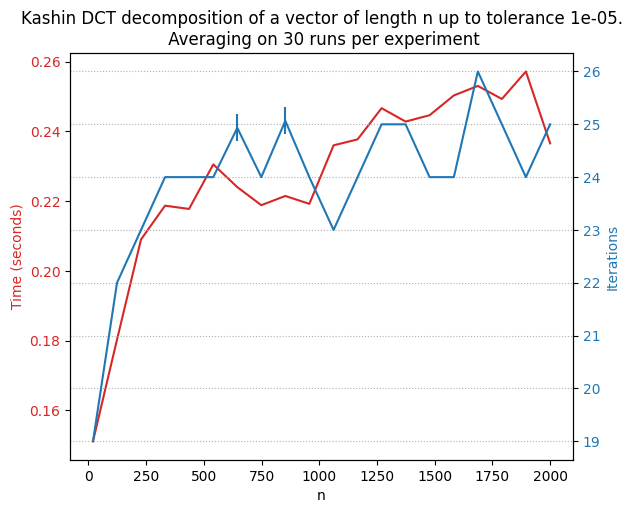

In [22]:
import jax.numpy as jnp
from jax import random, vmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import jax

# Modified function with jax.numpy.where
def decomposition_vector_dct(x, max_iter=50, tol=1e-6, key=random.PRNGKey(0)):
    n = len(x)   
    u, v = jnp.zeros(n), jnp.zeros(n)
    
    x_init = x.copy()

    def projection(x, y):
        return (x.T @ y / jnp.linalg.norm(y)**2) * y

    def body_fun(val):
        x, u, v, iter = val
        norm_x = jnp.linalg.norm(x, 1)
        norm_Qx = jnp.linalg.norm(dct(x, norm='ortho'), 1)

        proj = jnp.where(norm_x > norm_Qx, projection(x, jnp.sign(x)), projection(x, idct(jnp.sign(dct(x, norm='ortho')), norm='ortho')))
        u = u + proj
        x = x - proj

        return x, u, v, iter + 1

    def cond_fun(val):
        x, u, v, iter = val
        residual = jnp.linalg.norm(x_init - u - v)
        return (residual >= tol) & (iter < max_iter)

    x, u, v, iter = jax.lax.while_loop(cond_fun, body_fun, (x, u, v, 0))
    residual = jnp.linalg.norm(x_init - u - v)

    return x, u, v, residual, iter


# Define the range of dimensions and number of experiments
dimensions = np.linspace(20, 2000, num=20, dtype=int)
k = 30  # number of runs per setup
tolerance = 1e-5

# List to store results
results = []

for dim in dimensions:
    # keys = random.split(random.PRNGKey(0), k)  # Generate k random keys
    # A = jnp.array([[1. / (i + j + 0.5) for i in range(dim)] for j in range(dim)])
    x = random.normal(key, (dim,))
    x /= jnp.linalg.norm(x)
    
    # Batch the x_init and keys for vmap
    x_init_batch = jnp.array([x.copy() for _ in range(k)])
    key_batch = jnp.array(keys)

    # Vectorize the decomposition function
    vectorized_decomposition = vmap(decomposition_vector_dct, in_axes=(0, None, None, 0))

    start_time = time.time()
    # Run the vectorized function
    _, _, _, residuals, iterations = vectorized_decomposition(x_init_batch, 250, tolerance, key_batch)
    end_time = time.time()

    # Record results for each experiment
    for experiment in range(k):
        results.append({'Dimension': dim,
                        'Experiment': experiment + 1,
                        'Time': (end_time - start_time),  # Average time per experiment
                        'Iterations': iterations[experiment]})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Group by dimension and calculate mean and std
grouped_results = results_df.groupby('Dimension').agg(['mean', 'std'])


# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('n')
ax1.set_ylabel('Time (seconds)', color=color)
ax1.errorbar(dimensions, grouped_results['Time']['mean'], yerr=grouped_results['Time']['std'], color=color, label='Time')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Iterations', color=color)
ax2.errorbar(dimensions, grouped_results['Iterations']['mean'], yerr=grouped_results['Iterations']['std'], color=color, label='Iterations')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not clipped
plt.title(f'Kashin DCT decomposition of a vector of length n up to tolerance {tolerance}.\n Averaging on {k} runs per experiment')
plt.grid(linestyle=":")
plt.show()

## Matrix decomposition

## Dummy approach - vectorization

In [11]:
import jax.numpy as jnp
from jax import random

# Set the dimensions of the matrix
m, n = 100, 100  # for example, a 4x3 matrix

# Initialize a random number generator key
key = random.PRNGKey(0)

# Generate the random rectangular matrix
X = random.normal(key, (m, n))

print(f"💎 Generated random {m}x{n} matrix")

# Reshape X into a vector
X_vector = X.reshape(-1)
X_vector /= jnp.linalg.norm(X_vector)

# Apply the decomposition to the vectorized matrix
x, u, v, residual, iter = decomposition_vector(X_vector, max_iter=2000, tol=1e-6, key=key)

# Print results
print(f"💎 Done Kashin representation of random {m}x{n} matrix with {iter} iterations and residual {residual}")

💎 Generated random 100x100 matrix
💎 Done Kashin representation of random 100x100 matrix with 28 iterations and residual 9.880196785161388e-07


## Another approach

In [26]:
import jax.numpy as jnp
from jax import random
from jax.scipy.fft import dct, idct

RNG = random.PRNGKey(0)

def decomposition_matrix(X, max_iter=50, tol=1e-6, key=RNG):
    m, n = X.shape
    X_init = X.copy()
    U, V = jnp.zeros((m, n)), jnp.zeros((m, n))
    keys = random.split(key, 2)
    Q1, _ = jnp.linalg.qr(random.normal(keys[0], (m, m)))
    Q2, _ = jnp.linalg.qr(random.normal(keys[1], (n, n)))

    def projection(X, Y):
        # projection of X on Y
        return ((X.ravel()).T@Y.ravel()/jnp.linalg.norm(Y)**2)*Y

    iter = 0
    while iter < max_iter:
        Y = Q1.T @ X @ Q2
        if (jnp.linalg.norm(X.ravel(), 1) > jnp.linalg.norm(Y.ravel(), 1)):
            proj = projection(X, jnp.sign(X))
            U += proj
            X -= proj
        else:
            proj = projection(X, Q1 @ jnp.sign(Y) @ Q2.T)
            V += proj
            X -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(X_init - U - V)
        if residual < tol:
            break

        iter += 1

    return X, U, V, residual, iter, Q1, Q2

def decomposition_matrix_dct(X, max_iter=50, tol=1e-6, key=RNG):
    m, n = X.shape
    X_init = X.copy()
    U, V = jnp.zeros((m, n)), jnp.zeros((m, n))

    def projection(X, Y):
        # projection of X on Y
        return ((X.ravel()).T@Y.ravel()/jnp.linalg.norm(Y)**2)*Y

    iter = 0
    while iter < max_iter:
        # Y = Q1.T @ X @ Q2
        Y = (idct((idct(X, norm='ortho')).T, norm='ortho')).T
        if (jnp.linalg.norm(X.ravel(), 1) > jnp.linalg.norm(Y.ravel(), 1)):
            proj = projection(X, jnp.sign(X))
            U += proj
            X -= proj
        else:
            proj = projection(X, dct(dct(jnp.sign(Y), norm='ortho').T, norm='ortho').T)
            V += proj
            X -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(X_init - U - V)
        if residual < tol:
            break

        iter += 1

    return X, U, V, residual, iter

In [32]:
import jax.numpy as jnp
from jax import random

# Set the dimensions of the matrix
m, n = 2000, 2000

# Initialize a random number generator key
key = random.PRNGKey(0)

# Generate the random rectangular matrix
X = random.normal(key, (m, n))
X = X/jnp.linalg.norm(X)

print(f"💎 Generated random {m}x{n} matrix")

# Assuming decomposition_matrix and decomposition_matrix_dct are defined elsewhere
# Apply the decomposition to the vectorized matrix
%timeit X_, U, V, residual, iter, Q1, Q2 = decomposition_matrix(X, max_iter=300, tol=1e-6, key=RNG)

# Print results after the timing
print(f"💎 Done Kashin representation of random {m}x{n} matrix with {iter} iterations and residual {residual}")

# Apply the decomposition to the vectorized matrix
%timeit X_, U, V, residual, iter = decomposition_matrix_dct(X, max_iter=300, tol=1e-6, key=RNG)

# Print results after the timing
print(f"💎 Done DCT Kashin representation of random {m}x{n} matrix with {iter} iterations and residual {residual}")

💎 Generated random 2000x2000 matrix
4.79 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
💎 Done Kashin representation of random 2000x2000 matrix with 29 iterations and residual 7.576687721666531e-07
4.45 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
💎 Done DCT Kashin representation of random 2000x2000 matrix with 29 iterations and residual 7.576687721666531e-07


## LLM weights quantization

In [23]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /private/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/pip-req-build-l9d4rmal
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /private/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/pip-req-build-l9d4rmal
  Resolved https://github.com/huggingface/transformers to commit c475eca9cd9aa0b5a88b269b6a090b645391267d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for huggingface-hub<1.0,>=0.19.3 from https://files.pythonhosted.org/packages/28/03/7d3c7153113ec59cfb31e3b8ee773f5f420a0dd7d26d40442542b96675c3/huggingface_hub-0.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for tokenizers<0.19,>=0.14 from https://files.pythonhosted.org/packages/24/85/f319fd3d9855fd8b247a68d1c7c9d93bfc388369a35408ceb75ec2670ff5/tokenizers-0.15.1-cp39-cp39-macosx_11_0_

In [24]:
notebook_login()

In [25]:
tokenizer = AutoTokenizer.from_pretrained("stabilityai/stablelm-3b-4e1t")
model = AutoModelForCausalLM.from_pretrained("stabilityai/stablelm-3b-4e1t", trust_remote_code=True, torch_dtype=torch.float32)

RuntimeError: Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
cannot import name 'is_torch_xpu_available' from 'transformers.utils' (/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/transformers/utils/__init__.py)

In [ ]:
weight = model.model.layers[0].mlp.gate_proj.weight
weight.shape

torch.Size([6912, 2560])

In [ ]:
matrix = weight.detach().numpy(force = True)

In [ ]:
x = matrix[0, :] / jnp.linalg.norm(matrix[0, :])
print(jnp.linalg.norm(x, jnp.inf), 1. / jnp.sqrt(x.shape[0]))

0.058242317 0.019764235


In [9]:
def decomposition_matrix(A, iter, n1, n2, key):
    matrix = A[:n1, :n2]
    matrix /= jnp.linalg.norm(matrix)
    x = matrix.copy()

    u, v = jnp.zeros((n1, n2)), jnp.zeros((n1, n2))

    keys = random.split(key, 2)
    Q1, _ = jnp.linalg.qr(random.normal(keys[0], (n1, n1)))
    Q2, _ = jnp.linalg.qr(random.normal(keys[1], (n2, n2)))

    while iter > 0:
        y = Q1.T @ x @ Q2
        w, w_ = jnp.sign(x), jnp.sign(y)

        frac = (jnp.dot(w.ravel(), x.ravel()) > jnp.dot(w_.ravel(), y.ravel()))
        if frac:
            pass
        else:
            w = Q1 @ w_ @ Q2.T

        w /= jnp.linalg.norm(w)
        coef = jnp.dot(x.ravel(), w.ravel())
        x -= coef * w

        if frac:
            u += coef * w
        else:
            v += coef * w

        iter -= 1

    return x, u, v, Q1, Q2

In [10]:
def compute_uniformity(x):
    return (jnp.max(jnp.abs(x)) / jnp.linalg.norm(x.ravel())) * jnp.sqrt(x.size)

In [ ]:
key = random.PRNGKey(12)

n1, n2 = 1500, 1000
x, u, v, Q1, Q2 = decomposition_matrix(A=A, iter=200, n1=n1, n2=n2, key=key)

In [ ]:
print(jnp.linalg.norm(x), jnp.linalg.norm(u, jnp.inf), jnp.linalg.norm(Q1.T @ v @ Q2, jnp.inf))

0.0 0.28655016 0.6574427


In [ ]:
print(compute_uniformity(A[:n1,:n2]), compute_uniformity(u), compute_uniformity(Q1.T @ v @ Q2))

14.459311 1.660964 1.6665297


In [ ]:
jnp.linalg.norm(A[:n1, :n2] / jnp.linalg.norm(A[:n1, :n2]) - u - v)

Array(1.0506984e-07, dtype=float32)

In [ ]:
del model, matrix

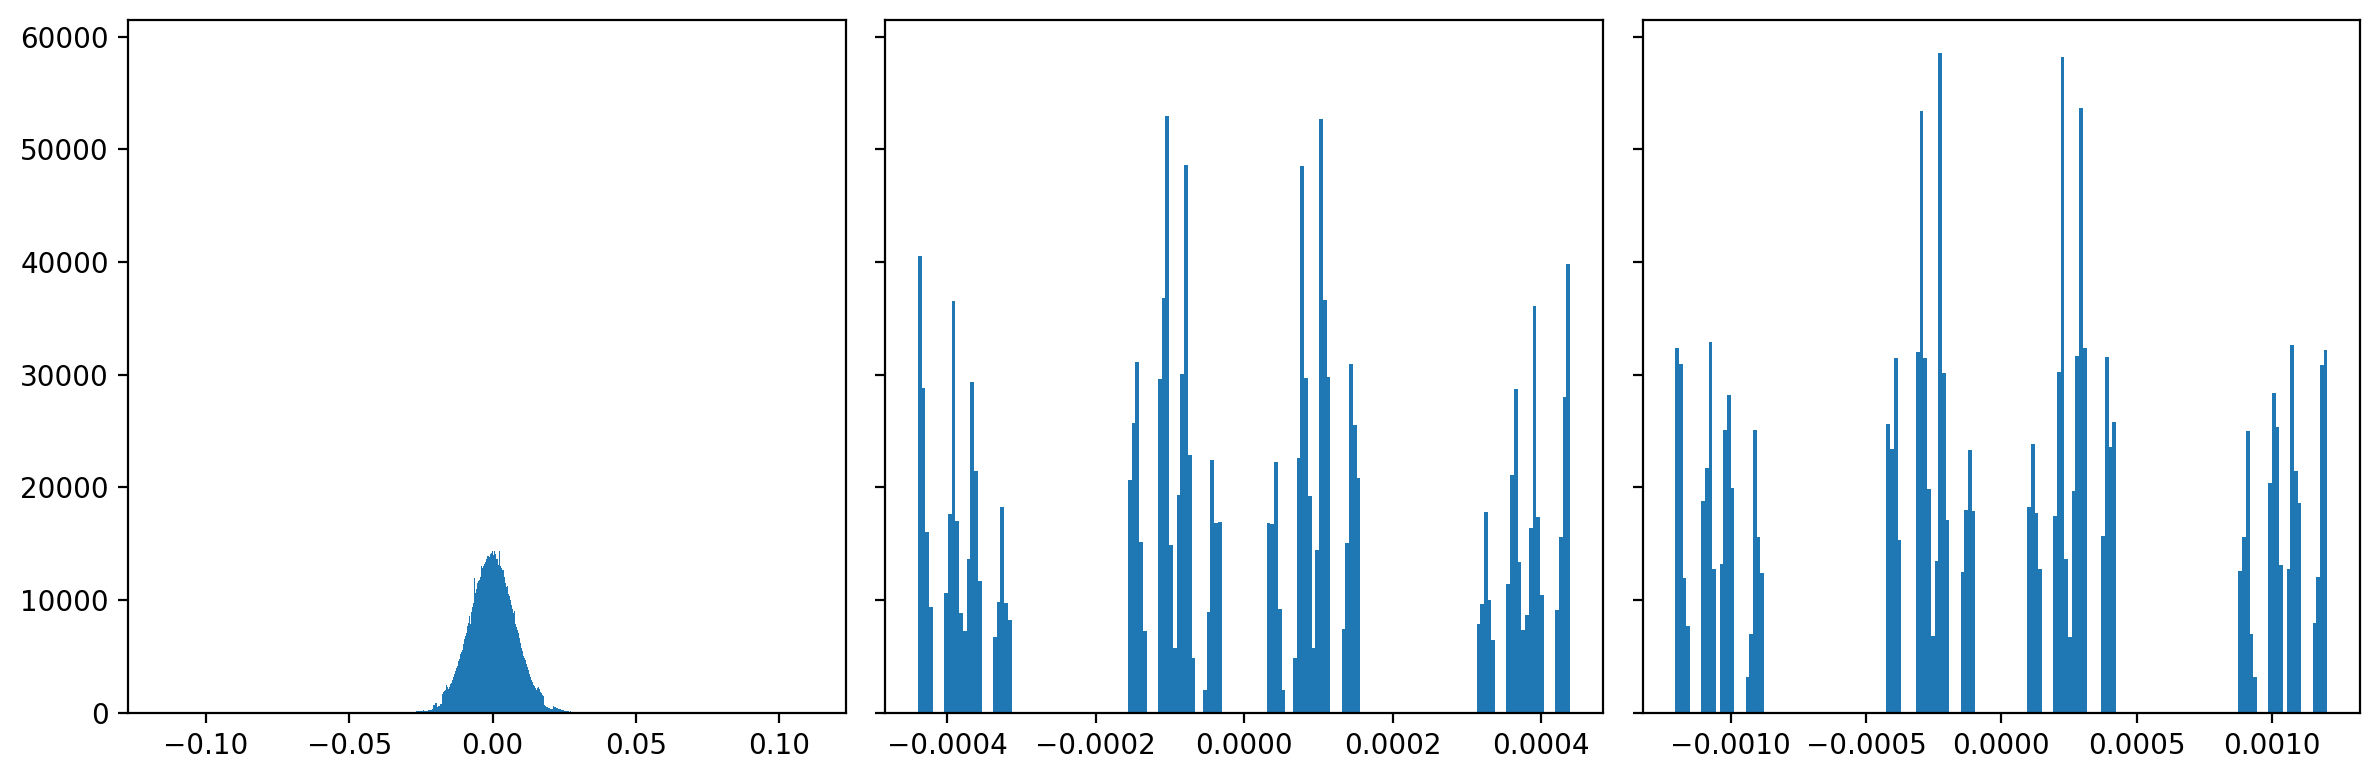

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12, 4))

axs[0].hist(A[:n1, :n2].ravel(), bins='auto')
axs[1].hist(u.ravel(), bins='auto')
axs[2].hist((Q1.T @ v @ Q2).ravel(), bins='auto');

inf-error: 0.03029383160173893
l2-error: 0.02060265652835369


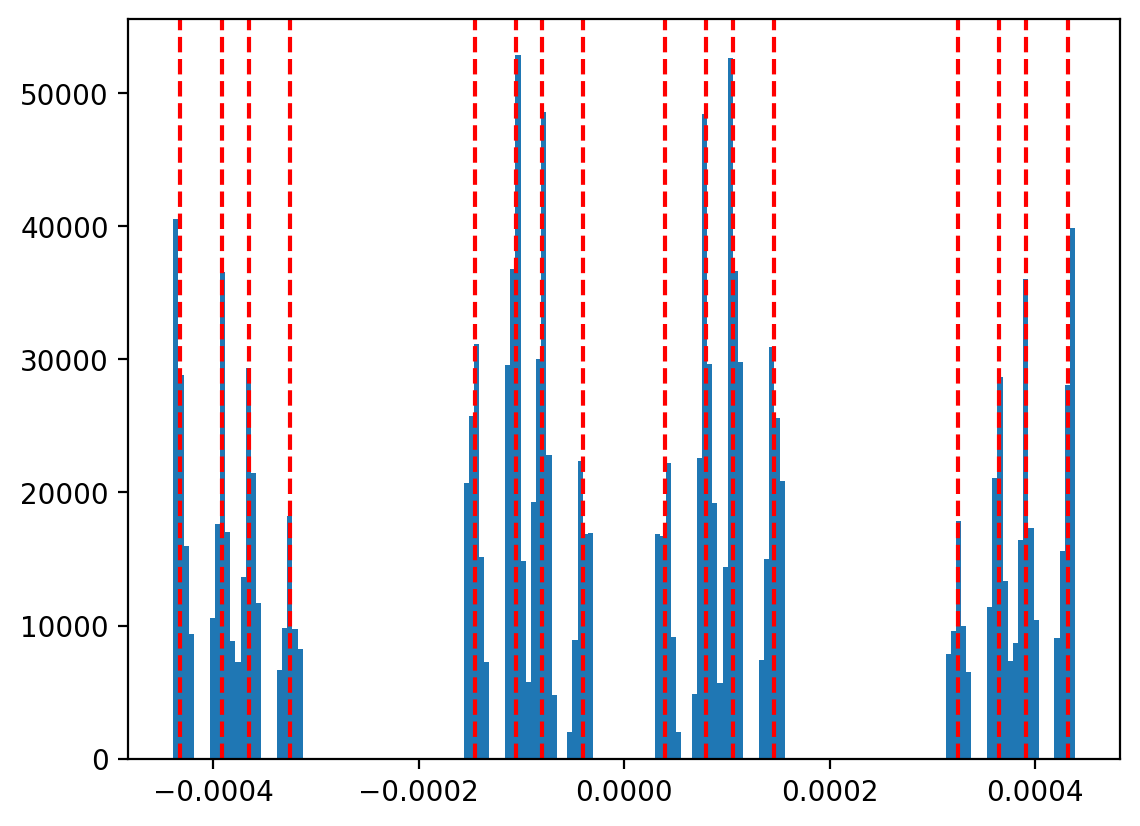

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

u_ = np.array(u.reshape(-1, 1))
k_means = KMeans(n_clusters=16, random_state=0).fit(u_)
clusters = k_means.cluster_centers_
plt.hist(u.ravel(), bins='auto')

for i in clusters:
    plt.axvline(x=i, color='r', linestyle='--')

# compute KMeans quantization error
labels = k_means.predict(u_)
approx = clusters[labels]

print(f'inf-error: {np.linalg.norm(u_ - approx, np.inf) / np.linalg.norm(approx, np.inf)}')
print(f'l2-error: {np.linalg.norm(u_ - approx) / np.linalg.norm(approx)}')

inf-error: 0.024669406935572624
l2-error: 0.01876361295580864


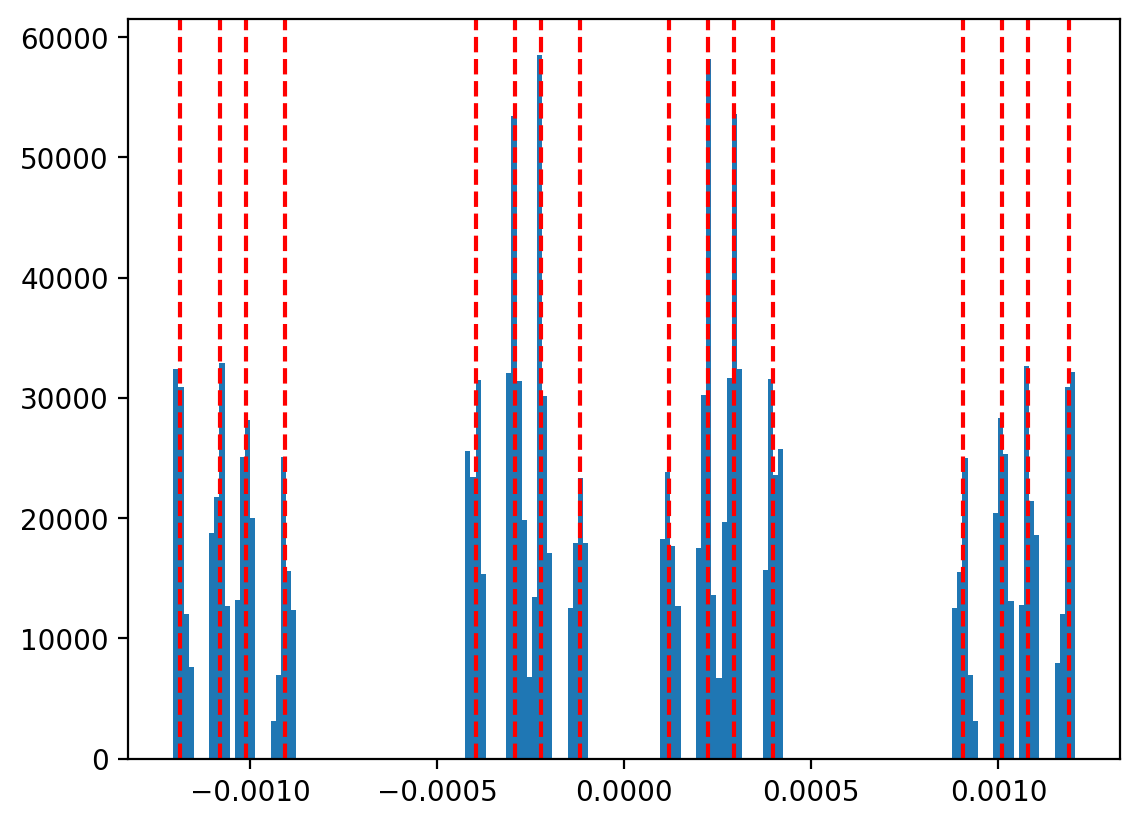

In [ ]:
v_ = np.array((Q1.T @ v @ Q2).reshape(-1, 1))
k_means = KMeans(n_clusters=16, random_state=0).fit(v_)
clusters = k_means.cluster_centers_
plt.hist((Q1.T @ v @ Q2).ravel(), bins='auto')

for i in clusters:
    plt.axvline(x=i, color='r', linestyle='--')

# compute KMeans quantization error
labels = k_means.predict(v_)
approx = clusters[labels]

print(f'inf-error: {np.linalg.norm(v_ - approx, np.inf) / np.linalg.norm(approx, np.inf)}')
print(f'l2-error: {np.linalg.norm(v_ - approx) / np.linalg.norm(approx)}')

inf-error: 3.389230251312256
l2-error: 0.11135271191596985


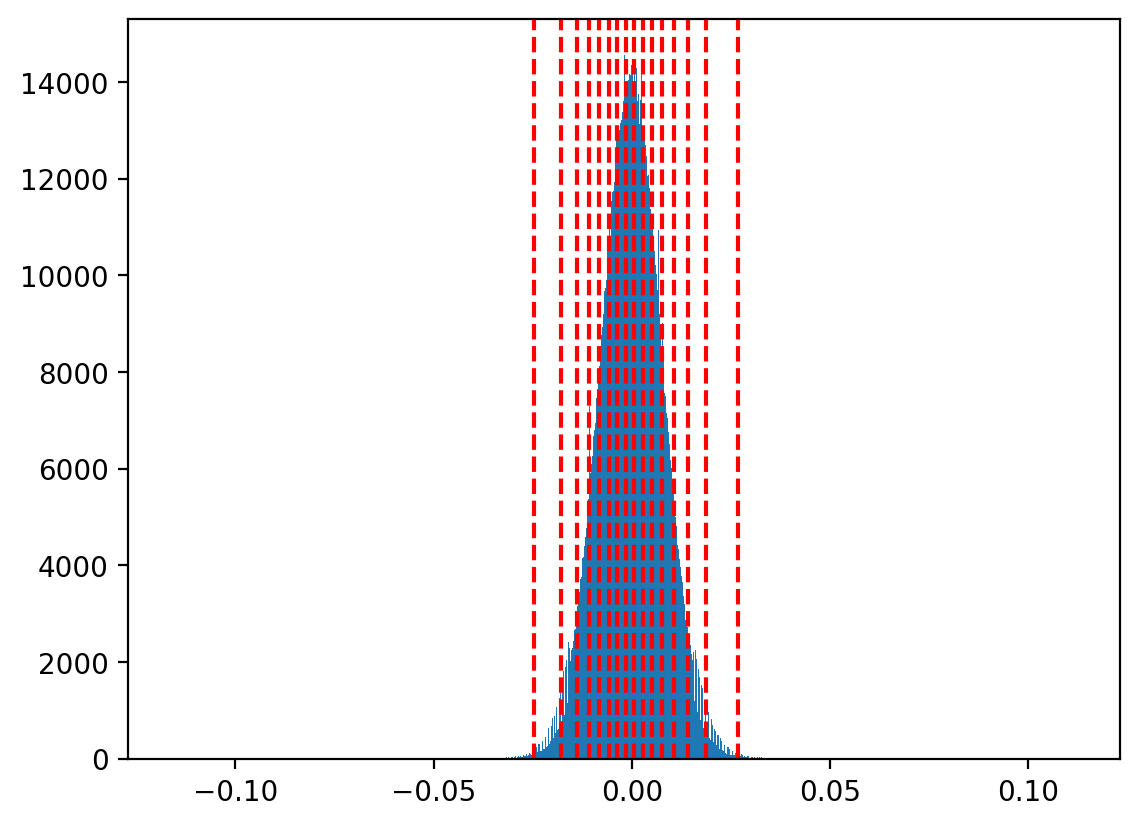

In [ ]:
A_ = np.array(A[:n1, :n2].reshape(-1, 1))
k_means = KMeans(n_clusters=16, random_state=0).fit(A_)
clusters = k_means.cluster_centers_

plt.hist(A_.ravel(), bins='auto')

for i in clusters:
    plt.axvline(x=i, color='r', linestyle='--')

labels = k_means.predict(A_)
approx = clusters[labels]

print(f'inf-error: {np.linalg.norm(A_ - approx, np.inf) / np.linalg.norm(approx, np.inf)}')
print(f'l2-error: {np.linalg.norm(A_ - approx) / np.linalg.norm(approx)}')

# Archive

In [ ]:
import jax.numpy as jnp
from jax import random
from jax.numpy.fft import fft, ifft

RNG = random.PRNGKey(0)

def decomposition_vector_fft(x, max_iter=50, tol=1e-6, key=RNG):
    n = len(x)
    x_init = x.copy()
    
    # Initialize vectors
    u, v = jnp.zeros(n), jnp.zeros(n)
    
    def projection(x, y):
        # projection of x on y
        return (x.T @ y / jnp.linalg.norm(y)**2) * y
    
    for iter in range(max_iter):
        # Perform FFT on the current vector and its sign for projections
        fft_x = fft(x, norm="ortho")
        sign_fft_x = fft(jnp.sign(ifft(fft_x, norm="ortho")), norm="ortho")

        # Original space projection
        if (jnp.linalg.norm(x, 1) > jnp.linalg.norm(ifft(sign_fft_x, norm="ortho"), 1)):
            proj = projection(x, jnp.sign(x))
            u += proj
            x -= proj
        # FFT space projection
        else:
            proj = projection(ifft(fft_x, norm="ortho"), ifft(sign_fft_x, norm="ortho"))
            proj = fft(proj, norm="ortho")  # Transform projection back
            v += proj
            x -= ifft(proj, norm="ortho")  # Keep x in the original space

        # Check if termination condition is met
        residual = jnp.linalg.norm(x_init - u - ifft(v, norm="ortho"))
        if residual < tol:
            break

    return x, u, ifft(v, norm="ortho"), residual, iter

# You can then use this function with your input vector 'x'.

In [ ]:
import scipy as sp
from scipy.fftpack import dct, idct

n = len(x)
# matrix = random.normal(key, (n, n))
# Q, _ = jnp.linalg.qr(matrix)
Q = sp.linalg.dft(n)/jnp.sqrt(n)
print(f"💎 x norm {jnp.linalg.norm(x)}")
print(f"💎 Qx norm {jnp.linalg.norm(Q@x)}")
print(f"💎 fft(x) norm {jnp.linalg.norm(fft(x_init, norm='ortho'))}")
Qx = fft(x_init)/jnp.sqrt(n)
print(f"💎 fft(x)/sqrt(n) norm {jnp.linalg.norm(Qx)}")
print(f"💎 Q.T Q x norm {jnp.linalg.norm(Q.T@Q@x_init)}")
print(f"💎 ifft(fft(x)/sqrt(n)) norm {jnp.linalg.norm(ifft(Qx, norm='ortho'))}")
Qty = ifft(Qx)*jnp.sqrt(n)
print(f"💎 ifft(fft(x)/sqrt(n))*sqrt(n) norm {jnp.linalg.norm(Qty)}")


In [ ]:
import scipy as sp
from scipy.fftpack import dct, idct

key = random.PRNGKey(42)
n = 300
A = jnp.array([[1. / (i + j + 0.5) for i in range(n)] for j in range(n)])

# нормируем первый столбец
x = np.array(A[:, 0] / jnp.linalg.norm(A[:, 0]))
x_init = x.copy()

n = len(x)
# matrix = random.normal(key, (n, n))
# Q, _ = jnp.linalg.qr(matrix)
Q = sp.linalg.dft(n)/jnp.sqrt(n)
print(f"💎 x norm {jnp.linalg.norm(x)}")
print(f"💎 Qx norm {jnp.linalg.norm(Q@x)}")
print(f"💎 dct(x) norm {jnp.linalg.norm(dct(x_init, norm='ortho'))}")
Qx = dct(x_init)/jnp.sqrt(n)
print(f"💎 dct(x)/sqrt(n) norm {jnp.linalg.norm(Qx)}")
print(f"💎 Q.T Q x norm {jnp.linalg.norm(Q.T@Q@x_init)}")
print(f"💎 idct(dct(x)/sqrt(n)) norm {jnp.linalg.norm(idct(Qx, norm='ortho'))}")
Qty = idct(Qx)*jnp.sqrt(n)
print(f"💎 idct(dct(x)/sqrt(n))*sqrt(n) norm {jnp.linalg.norm(Qty)}")


In [23]:
type(x)

jaxlib.xla_extension.ArrayImpl

/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


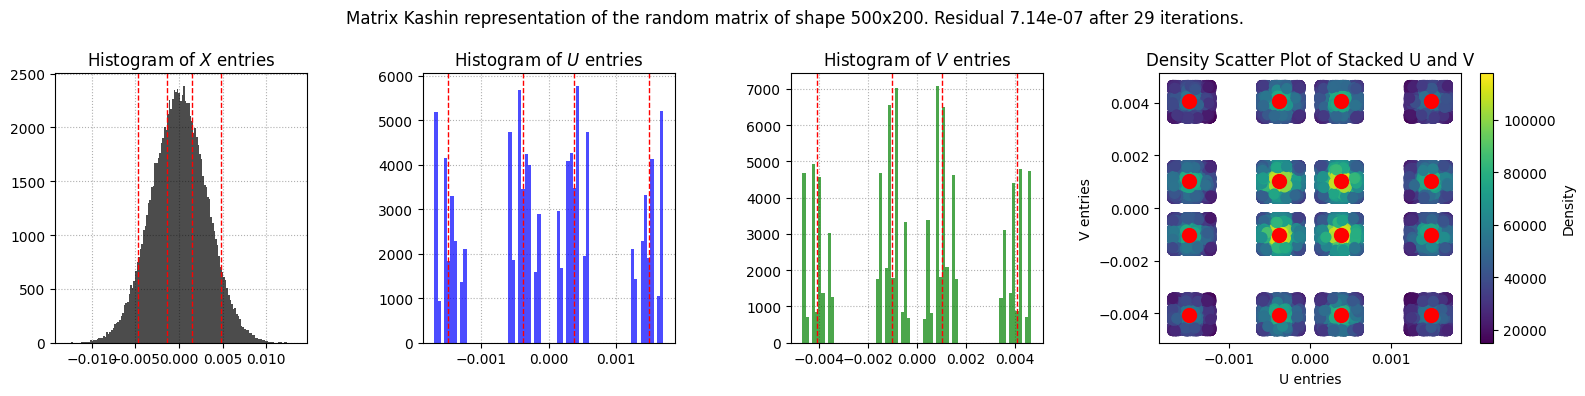

In [28]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde

import numpy as np

type = "DCT"
# type = "Random Q"

# Set the dimensions of the matrix
m, n = 500, 200

# Initialize a random number generator key
key = random.PRNGKey(0)

# Generate the random rectangular matrix
X = random.normal(key, (m, n))
X = X/jnp.linalg.norm(X)

import jax.numpy as jnp
from jax import random
from jax.scipy.fft import dct, idct

RNG = random.PRNGKey(0)

def decomposition_matrix(X, max_iter=50, tol=1e-6, key=RNG):
    m, n = X.shape
    X_init = X.copy()
    U, V_ = jnp.zeros((m, n)), jnp.zeros((m, n))
    keys = random.split(key, 2)
    Q1, _ = jnp.linalg.qr(random.normal(keys[0], (m, m)))
    Q2, _ = jnp.linalg.qr(random.normal(keys[1], (n, n)))

    def projection(X, Y):
        # projection of X on Y
        return ((X.ravel()).T@Y.ravel()/jnp.linalg.norm(Y)**2)*Y

    iter = 0
    while iter < max_iter:
        Y = Q1.T @ X @ Q2
        if (jnp.linalg.norm(X.ravel(), 1) > jnp.linalg.norm(Y.ravel(), 1)):
            proj = projection(X, jnp.sign(X))
            U += proj
            X -= proj
        else:
            proj = projection(X, Q1 @ jnp.sign(Y) @ Q2.T)
            V_ += proj
            X -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(X_init - U - V_)
        if residual < tol:
            break

        iter += 1

    return X, U, V_, residual, iter, Q1, Q2

def decomposition_matrix_dct(X, max_iter=250, tol=1e-6, key=RNG):
    m, n = X.shape
    X_init = X.copy()
    U, V_ = jnp.zeros((m, n)), jnp.zeros((m, n))

    def projection(X, Y):
        # projection of X on Y
        return ((X.ravel()).T@Y.ravel()/jnp.linalg.norm(Y)**2)*Y

    iter = 0
    while iter < max_iter:
        # Y = Q1.T @ X @ Q2
        Y = (idct((idct(X, norm='ortho')).T, norm='ortho')).T
        if (jnp.linalg.norm(X.ravel(), 1) > jnp.linalg.norm(Y.ravel(), 1)):
            proj = projection(X, jnp.sign(X))
            U += proj
            X -= proj
        else:
            proj = projection(X, dct(dct(jnp.sign(Y), norm='ortho').T, norm='ortho').T)
            V_ += proj
            X -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(X_init - U - V_)
        if residual < tol:
            break

        iter += 1

    return X, U, V_, residual, iter


if type == "DCT":
    # Decompose the matrix X
    X_, U, V_, residual, iter = decomposition_matrix_dct(X, max_iter=300, tol=1e-6, key=RNG)
    V = (idct((idct(V_, norm='ortho')).T, norm='ortho')).T
elif type == "Random Q":
    X_, U, V_, residual, iter, Q1, Q2 = decomposition_matrix(X, max_iter=300, tol=1e-6, key=key)
    V = Q1.T @ V_ @ Q2


# Plotting
plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1.5])  # Adjust the last ratio as needed for the wider plot
plt.suptitle(f"Matrix Kashin representation of the random matrix of shape {m}x{n}. Residual {residual:.2e} after {iter:n} iterations.")

# Histogram of X
ax = plt.subplot(gs[0])
plt.grid(linestyle=":")
ax.set_axisbelow(True)
plt.hist(X.ravel(), bins="auto", color='black', alpha=0.7)
plt.title('Histogram of $X$ entries')
k_means = KMeans(n_clusters=4, random_state=0).fit(X.reshape(-1, 1))
clusters = k_means.cluster_centers_
for i in clusters:
    plt.axvline(x=i, color='r', linestyle='--', linewidth=1)

# Histogram of U
ax = plt.subplot(gs[1])
plt.grid(linestyle=":")
ax.set_axisbelow(True)
plt.hist(U.ravel(), bins="auto", color='blue', alpha=0.7)
plt.title('Histogram of $U$ entries')
k_means = KMeans(n_clusters=4, random_state=0).fit(U.reshape(-1, 1))
u_clusters = k_means.cluster_centers_
for i in u_clusters:
    plt.axvline(x=i, color='r', linestyle='--', linewidth=1)

# Histogram of transformed V
ax = plt.subplot(gs[2])
plt.grid(linestyle=":")
ax.set_axisbelow(True)
plt.hist(V.ravel(),bins="auto", color='green', alpha=0.7)
plt.title(r'Histogram of $V$ entries')
k_means = KMeans(n_clusters=4, random_state=0).fit(V.reshape(-1, 1))
v_clusters = k_means.cluster_centers_
for i in v_clusters:
    plt.axvline(x=i, color='r', linestyle='--', linewidth=1)

# Density Scatter Plot of Stacked U and V
ax = plt.subplot(gs[3])
UV_stacked = np.column_stack((U.ravel(), V.ravel()))  # Assuming UV_stacked needs to be numpy array
xy = np.vstack([UV_stacked[:,0], UV_stacked[:,1]])
z = gaussian_kde(xy)(xy)
scatter = plt.scatter(UV_stacked[:, 0], UV_stacked[:, 1], c=z, s=50, cmap='viridis')
plt.colorbar(scatter, label='Density')
plt.title(f'Density Scatter Plot of Stacked U and V')
plt.xlabel('U entries')
plt.ylabel('V entries')
for cu, cv in itertools.product(u_clusters, v_clusters):
    plt.scatter(cu, cv, c='red', marker='o', s=100)

plt.tight_layout()
plt.savefig("random_matrix_quantization_combined.pdf")
plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde

# Assuming X, U, V are already defined and populated with your data processing above

# Function to plot and save histogram
def plot_histogram(data, title, color, filename, clusters):
    plt.figure(figsize=(4, 4))
    plt.hist(data.ravel(), bins="auto", color=color, alpha=0.7)
    plt.title(title)
    plt.grid(linestyle=":")
    for i in clusters:
        plt.axvline(x=i, color='r', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Function to plot and save density scatter
def plot_density_scatter(U, V, u_clusters, v_clusters, filename):
    plt.figure(figsize=(4, 4))
    UV_stacked = np.column_stack((U.ravel(), V.ravel()))
    xy = np.vstack([UV_stacked[:,0], UV_stacked[:,1]])
    z = gaussian_kde(xy)(xy)
    scatter = plt.scatter(UV_stacked[:, 0], UV_stacked[:, 1], c=z, s=50, cmap='viridis')
    plt.colorbar(scatter, label='Density')
    plt.title('Density Scatter Plot of Stacked U and V')
    plt.xlabel('U entries')
    plt.ylabel('V entries')
    for cu, cv in itertools.product(u_clusters, v_clusters):
        plt.scatter(cu, cv, c='red', marker='o', s=100)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Plot and save histograms
k_means_x = KMeans(n_clusters=4, random_state=0).fit(X.reshape(-1, 1))
x_clusters = k_means_x.cluster_centers_
plot_histogram(X, 'Histogram of $X$ entries', 'black', "histogram_X.pdf", x_clusters)

k_means_u = KMeans(n_clusters=4, random_state=0).fit(U.reshape(-1, 1))
u_clusters = k_means_u.cluster_centers_
plot_histogram(U, 'Histogram of $U$ entries', 'blue', "histogram_U.pdf", u_clusters)

k_means_v = KMeans(n_clusters=4, random_state=0).fit(V.reshape(-1, 1))
v_clusters = k_means_v.cluster_centers_
plot_histogram(V, 'Histogram of $\hat{V}$ entries', 'green', "histogram_V.pdf", v_clusters)

# Plot and save density scatter plot
plot_density_scatter(U, V, u_clusters, v_clusters, "density_scatter_UV.svg")


/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Grid seatch over vershynin

x 0.9999999403953552, Tx 0.9999998211860657
Qv 0.0
x - Tx 1.3978528556890524e-07
1.8284266
x 1.3978528556890524e-07, Tx 1.397852571471958e-07
Qv 2.8284265995025635
x - Tx 3.426113085185263e-14
1.8284267
x 3.426113085185263e-14, Tx 3.426112407558905e-14
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8284265995025635
x - Tx 0.0
1.8284267
x 0.0, Tx 0.0
Qv 2.8

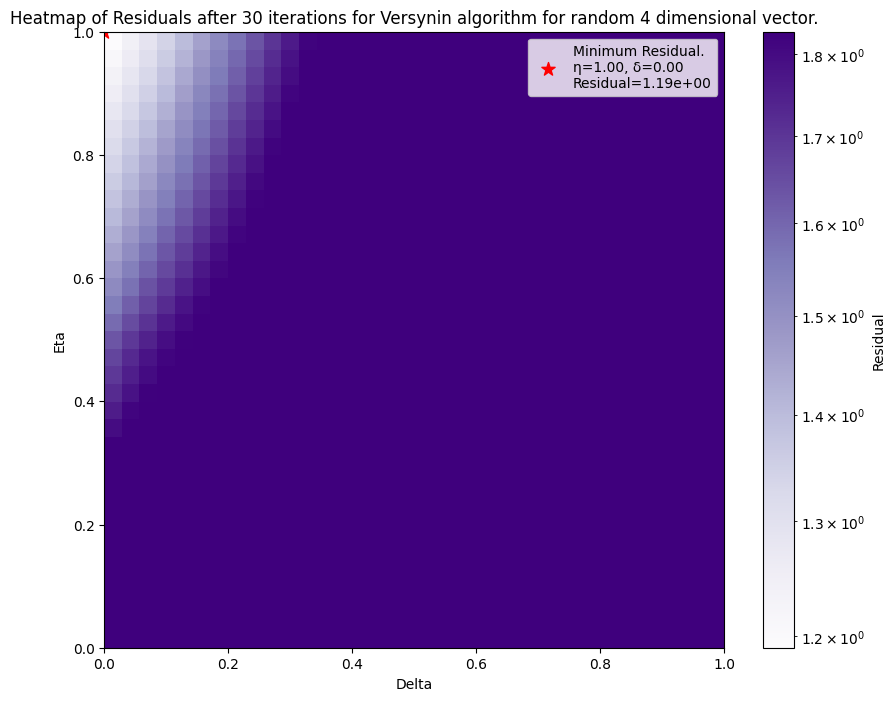

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
def decomposition_vector_vershynin(x, delta, eta, max_iter=50, tol=1e-6, key=RNG):
    n = len(x)
    m = int(2*n)
    matrix = random.normal(key, (m, m))
    
    # Perform QR decomposition on A.T to get Q of shape n x m
    Q_, _ = jnp.linalg.qr(matrix)
    
    # Select the first n rows from Q to get a matrix of shape n x m
    Q = Q_[:n, :]
    x_init = x.copy()

    def truncation(z, M=1):
        # Compute the absolute value of z
        abs_z = jnp.abs(z)
        # Apply the transformation
        t = jnp.where(abs_z == 0, 0, z / abs_z * jnp.minimum(abs_z, M))
        return t

    # init coefficients and the truncation level
    v = jnp.zeros(m)
    M = jnp.linalg.norm(x_init)/jnp.sqrt(delta*m)

    iter = 0
    while iter < max_iter:
        # print("x", x)

        proj = truncation(Q.T@x, M)
        print(f"x {jnp.linalg.norm(x)}, Tx {jnp.linalg.norm(Q@proj)}")
        print(f"Qv {jnp.linalg.norm(Q@v)}")
        
        x -= Q@proj
        print(f"x - Tx {jnp.linalg.norm(x)}")
        v += jnp.sqrt(m)*proj
        M *= eta

        # Check if termination condition is met
        residual = jnp.linalg.norm(x_init - Q@v)
        print(residual)
        if residual < tol:
            break

        iter += 1

    return x, v, residual, iter

# Initialize the parameters
key = random.PRNGKey(42)
n = 4
x = random.normal(key, (n,))
x /= jnp.linalg.norm(x)
x_init = x.copy()

# Define the grid search space for eta and delta
eta_values = jnp.linspace(0+1e-5, 1-1e-5, 35)
delta_values = jnp.linspace(0+1e-5, 1-1e-5, 35)

# Prepare matrix to store residuals
residuals = np.zeros((len(eta_values), len(delta_values)))

MAX_ITER = 30

# Perform grid search
for i, eta in enumerate(eta_values):
    for j, delta in enumerate(delta_values):
        _, _, residual, _ = decomposition_vector_vershynin(x_init, eta, delta, max_iter=MAX_ITER)
        residuals[i, j] = residual

# Find the minimum residual and its indices
min_residual = np.min(residuals)
min_idx = np.unravel_index(np.argmin(residuals), residuals.shape)
min_eta = eta_values[min_idx[0]]
min_delta = delta_values[min_idx[1]]

# Plotting
plt.figure(figsize=(10, 8))
im = plt.imshow(residuals, cmap='Purples', extent=[0,1,0,1], origin='lower', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar(im, label='Residual')
plt.xlabel('Delta')
plt.ylabel('Eta')
plt.title(f'Heatmap of Residuals after {MAX_ITER} iterations for Versynin algorithm for random {n} dimensional vector.')

# Plot the marker
plt.scatter(min_delta, min_eta, color='red', s=100, marker='*', label=f'Minimum Residual.\nη={min_eta:.2f}, δ={min_delta:.2f}\nResidual={min_residual:.2e}')
# Annotate the marker with eta, delta, and minimum residual
plt.legend()
plt.show()

In [ ]:
import jax.numpy as jnp
from jax import random

def generate_orthogonal_matrix(n, m, key):
    # Ensure n < m for the desired shape
    assert n < m, "n must be less than m"
    
    # Generate a random matrix A of shape m x m
    A = random.normal(key, (m, m))
    
    # Perform QR decomposition on A to get an orthogonal matrix Q of shape m x m
    Q, _ = jnp.linalg.qr(A)
    
    # Select the first n rows from Q to get a matrix of shape n x m
    Q_n_m = Q[:n, :]
    
    return Q_n_m

# Example usage
key = random.PRNGKey(0)
n, m = 5, 10  # n < m
Q = generate_orthogonal_matrix(n, m, key)
print("Shape of Q:", Q.shape)

(Q.T @ Q).shape
Q @ Q.T


Shape of Q: (5, 10)


Array([[ 9.9999988e-01, -1.4271370e-07, -1.6978696e-07,  2.9949632e-08,
         1.2320746e-07],
       [-1.4271370e-07,  1.0000000e+00,  4.4574211e-10, -1.2141202e-08,
         7.2882371e-09],
       [-1.6978696e-07,  4.4574211e-10,  1.0000004e+00,  7.7374999e-08,
        -2.6259126e-08],
       [ 2.9949632e-08, -1.2141202e-08,  7.7374999e-08,  1.0000000e+00,
         4.0667299e-08],
       [ 1.3810862e-07,  7.2882371e-09, -1.8808546e-08,  4.8117879e-08,
         1.0000001e+00]], dtype=float32)

In [ ]:
z = jnp.ones(5)
z
def truncation(z, M=0.9):
    # Compute the absolute value of z
    abs_z = jnp.abs(z)
    # Apply the transformation
    t = jnp.where(abs_z == 0, 0, z / abs_z * jnp.minimum(abs_z, M))
    return t

truncation(z)

Array([0.9, 0.9, 0.9, 0.9, 0.9], dtype=float32)